In [146]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

In [147]:
# Specify the center location (latitude, longtitude)
##japan
CENTER_LOCATION = (35.6889646, 139.7816839)

##india 
##CENTER_LOCATION = (22.7149, 75.8899)

# Specify distance in meters
DIST = 350  ##range of map you want around centre

# Specify the number of vehicles
NUM_VEHICLES = 10

/tmp/ipykernel_37927/3682450694.py:4: FutureWarning: The `get_largest_component` function is deprecated and will be removed in the v2.0.0 release. Replace it with `truncate.largest_component` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.utils_graph.get_largest_component(G, strongly=True)


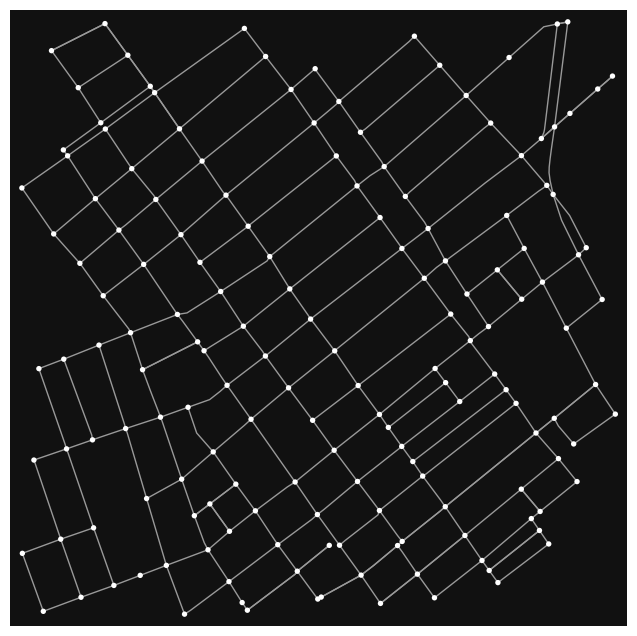

Node 260102622: Coordinates (139.7847558, 35.6902959)
Node 345121604: Coordinates (139.7846046, 35.6908796)
Node 345135706: Coordinates (139.7845355, 35.6878048)
Node 603556070: Coordinates (139.778995, 35.6920794)
Node 603556253: Coordinates (139.7792889, 35.6917494)
Node 603556499: Coordinates (139.7786511, 35.6914105)
Node 603556624: Coordinates (139.7789409, 35.6910441)
Node 603556625: Coordinates (139.7793392, 35.6905649)
Node 603584647: Coordinates (139.77846, 35.6907607)
Node 1054155120: Coordinates (139.7799259, 35.689043)
Node 1054155154: Coordinates (139.7810573, 35.6886089)
Node 1054155189: Coordinates (139.7805505, 35.6902883)
Node 1054155212: Coordinates (139.781638, 35.6889946)
Node 1054155216: Coordinates (139.778465, 35.688576)
Node 1054155222: Coordinates (139.7799527, 35.6909809)
Node 1054155234: Coordinates (139.7796486, 35.6902434)
Node 1054155249: Coordinates (139.7808356, 35.6899639)
Node 1054155265: Coordinates (139.7783074, 35.6917971)
Node 1054155353: Coordinat

In [148]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

# Get the coordinates of each node in the graph
node_coordinates = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Print the coordinates of each node
for node, coordinates in node_coordinates.items():
    print(f"Node {node}: Coordinates {coordinates}")


In [149]:
# Use the nearest node to the center location as the depot
##to do select depot location
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])  ##locations of depot

##select hotspot location
##rn exsisting node
hotspot_id =  9965375845
hotspot_location = (G.nodes[hotspot_id]['y'], G.nodes[hotspot_id]['x'])  # Adjust this as needed
hotspot = ox.distance.nearest_nodes(G, hotspot_location[1], hotspot_location[0])

In [150]:
# To do : replace this with customer orders
##how generate actual order locations  coordinates
##predined geometry of bus stops

orders = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
orders_nodes = list(map(itemgetter(1), orders.index.values))
orders_nodes[:5]


/tmp/ipykernel_37927/70411485.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  orders = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)


[1892744308, 2264347181, 2365964047, 3977436330, 6376128150]

In [151]:
# Combine depot and hotspots to customers
##get id of each node
nodes = [depot] + orders_nodes + [hotspot]  #depot 0th node , hotspot last node  
print(nodes) ##first depot last hotspot

[1054155212, 1892744308, 2264347181, 2365964047, 3977436330, 6376128150, 9510182277, 9510182278, 9712992081, 9965375845]


In [152]:
# Add order points to the highway graph
for index, order in orders.iterrows(): 
    ##nearest node  actual point on world to order location
    nearest_node = ox.distance.nearest_nodes(G, order.geometry.x, order.geometry.y)
    ## distance between the nearest node and the current order point
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (order.geometry.y, order.geometry.x))
    ##add order point to ,map
    G.add_node(index[1], x=order.geometry.x, y=order.geometry.y)
    
    # Add bidirectional edge
    G.add_edge(index[1], nearest_node, weight=distance.m)
    G.add_edge(nearest_node, index[1], weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head()


osmid oneway   name   highway reversed   length  \
u         v          key                                                        
260102622 3719485523 0    368086828   True  清洲橋通り  tertiary    False   73.149   
          3719485538 0    368086832   True  清洲橋通り  tertiary    False   76.199   
345121604 1691781360 0     31046679  False   御幸通り  tertiary    False   20.424   
          5929256269 0     21910839   True   清杉通り  tertiary    False  134.521   
345135706 1093866779 0    156942563  False   金座通り  tertiary     True   27.256   

                                                                   geometry  \
u         v          key                                                      
260102622 3719485523 0    LINESTRING (139.78476 35.69030, 139.78497 35.6...   
          3719485538 0    LINESTRING (139.78476 35.69030, 139.78486 35.6...   
345121604 1691781360 0    LINESTRING (139.78460 35.69088, 139.78477 35.6...   
          5929256269 0    LINESTRING (139.78460 35.69088, 139.78464 35.6...   
345135706 1093866779 0    LINESTRING (139.78454 35.68780, 139.78477 35.6...   

                         lanes maxspeed  ref access  weight  
u         v          key                                     
260102622 3719485523 0     NaN      NaN  NaN    NaN     NaN  
          3719485538 0     NaN      NaN  NaN    NaN     NaN  
345121604 1691781360 0     NaN      NaN  NaN    NaN     NaN  
          5929256269 0     NaN      NaN  NaN    NaN     NaN  
345135706 1093866779 0     NaN      NaN  NaN    NaN     NaN

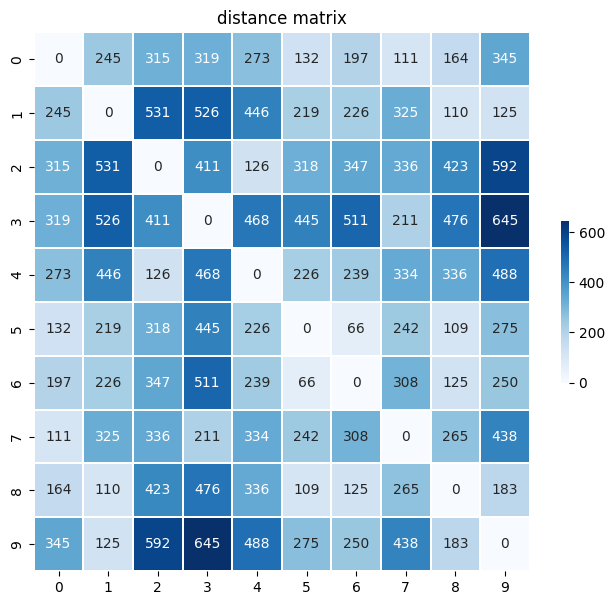

In [153]:
# Initialize an empty distance matrix
distance = {}

# Compute the pairwise distances between all nodes
for i in nodes:
    for j in nodes:
        # Calculate the distance between node i and node j
        distance[(i, j)] = geopy.distance.distance((G.nodes[i]['y'], G.nodes[i]['x']),
                                                    (G.nodes[j]['y'], G.nodes[j]['x'])).meters


#Convert the distance dictionary to a matrix
#Assuming orders_nodes is a list of node IDs
n = len(nodes)
distances = [[distance[(nodes[i], nodes[j])] for j in range(n)] for i in range(n)]
distances = np.array(distances)

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()    

In [154]:
# solve with pulp

def Optimize(vehicle_count,customer_count,x,distances,vehicle_capacity =3): ##distance is a distange matric

    for vehicle_count in range(1,vehicle_count+1):

        # definition of LpProblem instance
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        # definition of variables which are 0/1
        ##already includes constaraint sum(Xii) = 0
        x = x
        #x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
        u = pulp.LpVariable.dicts('u', (i for i in range(1, customer_count)), lowBound=0, cat='Continuous')

        # add objective function
        problem += pulp.lpSum(distances[i][j] * x[i][j][k] if i != j else 0
                            for k in range(vehicle_count)
                            for j in range(customer_count)
                            for i in range (customer_count))

        #constraints

    # pickup all points with exact;y one cab
        for j in range(1,customer_count-1):
            problem += pulp.lpSum(x[i][j][k] for i in range(customer_count) for k in range(vehicle_count)) == 1


        #depart from 0
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 0

        #arrive at 15
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[i][customer_count-1][k] for i in range(customer_count-1)) == 1
            problem += pulp.lpSum(x[customer_count-1][j][k] for j in range(customer_count-1)) == 0


        ##given vehicle demand is less than capacity
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                for i in range(customer_count) for j in range(customer_count)) <= vehicle_capacity

    #if arrive then leave
        for k in range(vehicle_count):
            for j in range(1,customer_count-1):
                problem += pulp.lpSum( pulp.lpSum(x[i][j][k] for i in range(0,customer_count-1)) ) == ( pulp.lpSum(x[j][m][k] for m in range(1,customer_count)) )

    # xij and xji not both 1
        for k in range(vehicle_count):
            for j in range(1,customer_count-1):
                for i in range(1,customer_count-1):
                    if (x[i][j][k] if i != j else 0  ==1 ):
                        problem += x[j][i][k] ==0

        #elimnate subtours
        # Subtour Elimination (MTZ constraints)
        for i in range(1, customer_count):
            problem += u[i] >= 1  # Ensures that each node (except the depot) is visited at least once
            problem += u[i] <= customer_count - 1  # Sets an upper bound for u[i]
        for k in range(vehicle_count):
            for i in range(1, customer_count):
                for j in range(1, customer_count):
                    if i != j:
                        problem += u[i] - u[j] + (customer_count - 1) * x[i][j] <= customer_count- 2

    # solve problem
        status = problem.solve()
        print(status)


        if status == 1:
            print('Vehicle Requirements:', vehicle_count)
            print('Moving Distance:', pulp.value(problem.objective))
            return vehicle_count
            break
    

In [155]:
print(NUM_VEHICLES)
x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(NUM_VEHICLES)]for j in range(n)] for i in range(n)]
v = Optimize(NUM_VEHICLES,n,x,distances)

10
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0218e09599594f42a1391d0f4f47c5e8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/0218e09599594f42a1391d0f4f47c5e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 116 COLUMNS
At line 2891 RHS
At line 3003 BOUNDS
At line 3742 ENDATA
Problem MODEL has 111 rows, 747 columns and 1208 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

-1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c79fba9ebc88483b92566babe10caa3f-pulp.mps -timeMo

In [164]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# # Plot customer locations
# for index, order in orders.iterrows():
#     stop_coords = (order.geometry.y, order.geometry.x)
#     folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']
routes = []
for k in range(v):
    # Get routes for each vehicle
    vehicle_routes = [(i, j) for i in range(n) for j in range(n) if i != j and pulp.value(x[i][j][k]) == 1]

    # Choose color for this vehicle
    color = colors[k % len(colors)]  # Cycle through colors if more vehicles than colors

    # Plot each route for this vehicle
    for i, j in vehicle_routes:
        # Get the coordinates of the nodes i and j
        coord_i = (G.nodes[nodes[i]]['y'], G.nodes[nodes[i]]['x'])
        coord_j = (G.nodes[nodes[j]]['y'], G.nodes[nodes[j]]['x'])

        # Add markers for depot, hotspot, and customer nodes
        folium.Marker((G.nodes[hotspot]['y'], G.nodes[hotspot]['x']), icon=folium.Icon(color="red"), popup="Hotspot").add_to(m)
        folium.Marker((G.nodes[depot]['y'], G.nodes[depot]['x']), icon=folium.Icon(color="green"), popup="Depot").add_to(m)
        for customer_node in orders_nodes:
            folium.Marker((G.nodes[customer_node]['y'], G.nodes[customer_node]['x']), icon=folium.Icon(color="black"), popup="Customer").add_to(m)

        # Draw a line between the nodes to represent the route
        folium.PolyLine([coord_i, coord_j], color=color, weight=2.5, opacity=1).add_to(m)

# Display the map
m

In [165]:
# Create a Folium map centered at a specific location
m = folium.Map(location=CENTER_LOCATION, zoom_start=12)
colors = ['blue', 'orange', 'purple', 'green']
# Plot routes
for k in range(v):
    # Get routes for each vehicle
    vehicle_routes = [(i, j) for i in range(n) for j in range(n) if i != j and pulp.value(x[i][j][k]) == 1]

    # Choose color for this vehicle
    color = colors[k % len(colors)]  # Cycle through colors if more vehicles than colors

    # Plot each route for this vehicle
    for i, j in vehicle_routes:
        route_nodes = nx.shortest_path(G, nodes[i], nodes[j], weight='length')
        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route_nodes]
        
        # Add markers for depot, hotspot, and customer nodes
        folium.Marker((G.nodes[hotspot]['y'], G.nodes[hotspot]['x']), icon=folium.Icon(color="red"), popup="Hotspot").add_to(m)
        folium.Marker((G.nodes[depot]['y'], G.nodes[depot]['x']), icon=folium.Icon(color="green"), popup="Depot").add_to(m)
        for customer_node in orders_nodes:
            folium.Marker((G.nodes[customer_node]['y'], G.nodes[customer_node]['x']), icon=folium.Icon(color="black"), popup="Customer").add_to(m)

        # Draw a line between the route nodes to represent the route
        folium.PolyLine(route_coords, color=color, weight=2.5, opacity=1).add_to(m)

# Display the map
m
